In [1]:
import pandas as pd
import numpy as np
import ast

from data_augmenter import duplicate_and_flip_actions, create_action_windows, augment_all_actions, explode_keypoints
from data_visualization import draw_random_frame, draw_random_window, show_stats

PATH_KEYPOINTS_FILTERED             = "../Data/tmp/keypoints_filtered.csv"
PATH_METADATA                       = "../Data/Processed/metadata.csv"
PATH_DATA                           = "../Data/Processed/data.csv"

WINDOW_SIZE                         = 8
WINDOWS_PER_ACTION                  = 5

JITTER_STD                          = 2.5
NOISE_STD                           = 2.5
SCALE_STD                           = 0.075
ROTATE_DEG                          = 7

In [2]:
df_keypoints = pd.read_csv(PATH_KEYPOINTS_FILTERED)

df_keypoints["box"] = df_keypoints["box"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

df_keypoints["keypoints"] = df_keypoints["keypoints"].apply(
    lambda x: [tuple(p) for p in ast.literal_eval(x)] if isinstance(x, str) else x
)

In [3]:
def interpolate_short_actions(df, min_frames=8):
    df_out = []

    for action_id, group in df.groupby("action_id"):
        group = group.sort_values("frame").reset_index(drop=True)
        n_frames = len(group)

        if n_frames >= min_frames:
            df_out.append(group)
            continue

        interp_rows = []

        # --- Interpolate keypoints between consecutive frames ---
        for i in range(n_frames - 1):
            row_start = group.iloc[i]
            row_end = group.iloc[i + 1]

            # Determine how many interpolated frames between start and end
            n_interp_between = int(np.ceil((min_frames - 1) / (n_frames - 1)))

            for j in range(n_interp_between):
                alpha = j / n_interp_between
                new_row = row_start.copy()

                # Interpolate keypoints
                kp_start = np.array(row_start["keypoints"])
                kp_end = np.array(row_end["keypoints"])
                kp_new = (1 - alpha) * kp_start + alpha * kp_end
                new_row["keypoints"] = [tuple(pt) for pt in kp_new]

                interp_rows.append(new_row)

        # Add the last original frame
        interp_rows.append(group.iloc[-1].copy())

        # --- Recalculate frame numbers sequentially ---
        start_frame = group["start_frame"].iloc[0]
        for i, r in enumerate(interp_rows):
            r["frame"] = start_frame + i
            # Keep all other columns the same
            r["start_frame"] = start_frame
            r["end_frame"] = start_frame + len(interp_rows) - 1

        df_out.append(pd.DataFrame(interp_rows))

    return pd.concat(df_out, ignore_index=True)

In [4]:
df_interp = interpolate_short_actions(df_keypoints)
df_interp = df_interp.sort_values(["action_id", "frame"]).reset_index(drop=True)
show_stats(df_interp)

action,min,max,mean,std,count
ATTACK_LUNGE,8,13,10.952222,1.929827,1800
ATTACK_STOP_CUT,8,15,10.088710,1.408557,496
ATTACK_STEP_CUT,8,13,10.656325,1.401051,419
ATTACK_BEAT,8,13,9.952381,1.056201,315
ATTACK_COUNTER,9,13,10.272727,1.157491,264
ATTACK_RIPOSTE,8,13,9.857143,1.360672,126
ATTACK_FLUNGE,8,13,10.411765,1.464788,102
ATTACK_FEINT,9,11,9.921348,0.568585,89
ATTACK_REMISE,9,11,10.066667,0.820638,60
action,min,max,mean,std,count


Total Offensive Frames: 3671
Total Defensive Frames: 2164

Total Frames: 5835
Total classes:  14



In [5]:
df_flipped = duplicate_and_flip_actions(
    df_interp, 
    image_width=1920
)

print(df_flipped)

print("Number of actions before flipping: ", df_keypoints["action_id"].nunique())
print("Number of actions after flipping:  ", df_flipped["action_id"].nunique())

                file fencer  action_id          action  frame  start_frame  \
0      1/10_Left.mp4   LEFT          0    ATTACK_LUNGE     23           23   
1      1/10_Left.mp4   LEFT          0    ATTACK_LUNGE     24           23   
2      1/10_Left.mp4   LEFT          0    ATTACK_LUNGE     25           23   
3      1/10_Left.mp4   LEFT          0    ATTACK_LUNGE     26           23   
4      1/10_Left.mp4   LEFT          0    ATTACK_LUNGE     27           23   
...              ...    ...        ...             ...    ...          ...   
11665   6/9_Left.mp4   LEFT        948  ATTACK_COUNTER     46           38   
11666   6/9_Left.mp4   LEFT        948  ATTACK_COUNTER     47           38   
11667   6/9_Left.mp4   LEFT        948  ATTACK_COUNTER     48           38   
11668   6/9_Left.mp4   LEFT        948  ATTACK_COUNTER     49           38   
11669   6/9_Left.mp4   LEFT        948  ATTACK_COUNTER     50           38   

       end_frame                           box  confidence  \
0

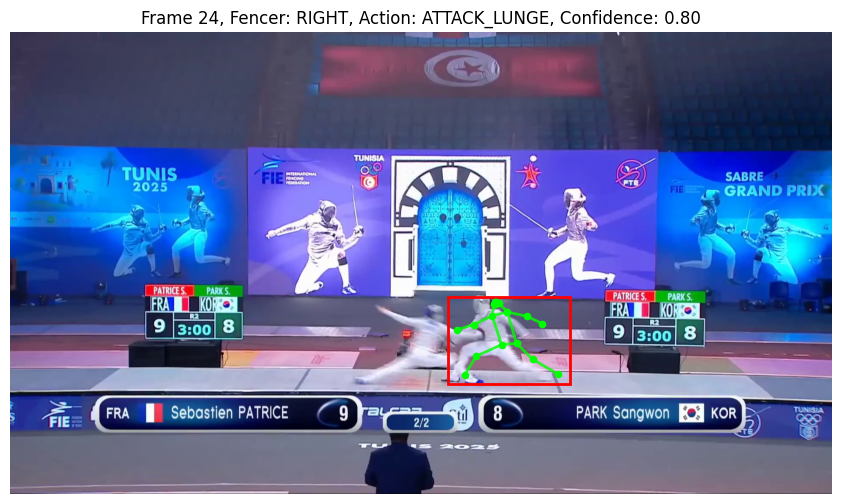

In [6]:
start_idx = len(df_keypoints)
df_flipped_only = df_flipped[df_flipped.index > start_idx]
draw_random_frame(df_flipped_only)

In [7]:
action_counts = df_flipped.groupby("action")["action_id"].nunique().sort_values(ascending=False)

print(action_counts)

action
ATTACK_LUNGE             340
DEFENSE_DISTANCE_PULL    130
ATTACK_STOP_CUT          100
ATTACK_STEP_CUT           80
ATTACK_BEAT               64
DEFENSE_POINT_IN_LINE     62
ATTACK_COUNTER            52
ATTACK_RIPOSTE            26
ATTACK_FLUNGE             20
ATTACK_FEINT              18
DEFENSE_PARRY_4           18
DEFENSE_PARRY_5           14
ATTACK_REMISE             12
DEFENSE_PARRY_2           12
Name: action_id, dtype: int64


In [8]:
max_count = action_counts.max()
class_weights = max_count / action_counts
weights_dict = class_weights.to_dict()

print(class_weights)

action
ATTACK_LUNGE              1.000000
DEFENSE_DISTANCE_PULL     2.615385
ATTACK_STOP_CUT           3.400000
ATTACK_STEP_CUT           4.250000
ATTACK_BEAT               5.312500
DEFENSE_POINT_IN_LINE     5.483871
ATTACK_COUNTER            6.538462
ATTACK_RIPOSTE           13.076923
ATTACK_FLUNGE            17.000000
ATTACK_FEINT             18.888889
DEFENSE_PARRY_4          18.888889
DEFENSE_PARRY_5          24.285714
ATTACK_REMISE            28.333333
DEFENSE_PARRY_2          28.333333
Name: action_id, dtype: float64


In [9]:
df_windowed = create_action_windows(
    df_flipped, 
    window_size=WINDOW_SIZE, 
    base_windows=WINDOWS_PER_ACTION,
    class_weights=weights_dict, 
    random_state=42
)

new_action_counts = df_windowed.groupby("action")["window_id"].nunique().sort_values(ascending=False)
print(new_action_counts)
print("")
print("Number of action snippets: ", df_windowed["window_id"].nunique())

action
ATTACK_BEAT              1728
ATTACK_COUNTER           1716
ATTACK_REMISE            1704
DEFENSE_PARRY_2          1704
ATTACK_LUNGE             1700
ATTACK_FLUNGE            1700
ATTACK_STOP_CUT          1700
DEFENSE_PARRY_5          1694
ATTACK_FEINT             1692
DEFENSE_PARRY_4          1692
ATTACK_RIPOSTE           1690
DEFENSE_DISTANCE_PULL    1690
ATTACK_STEP_CUT          1680
DEFENSE_POINT_IN_LINE    1674
Name: window_id, dtype: int64

Number of action snippets:  23764


In [10]:
df_augmented = augment_all_actions(df_windowed,
    jitter_std=JITTER_STD,
    noise_std=NOISE_STD,
    scale_std=SCALE_STD,
    rotate_deg=ROTATE_DEG
)

df_augmented = df_augmented[
    ["file", "fencer", "action_id", "window_id", "action", "frame", "start_frame", "end_frame", "box", "confidence", "keypoints"]
].sort_values(["file", "action_id", "window_id", "frame"]).reset_index(drop=True)

print(df_augmented)
print("")

                 file fencer  action_id  window_id          action  frame  \
0       1/10_Left.mp4   LEFT          0          1    ATTACK_LUNGE     23   
1       1/10_Left.mp4   LEFT          0          1    ATTACK_LUNGE     24   
2       1/10_Left.mp4   LEFT          0          1    ATTACK_LUNGE     25   
3       1/10_Left.mp4   LEFT          0          1    ATTACK_LUNGE     26   
4       1/10_Left.mp4   LEFT          0          1    ATTACK_LUNGE     27   
...               ...    ...        ...        ...             ...    ...   
190107   6/9_Left.mp4   LEFT        948      23764  ATTACK_COUNTER     42   
190108   6/9_Left.mp4   LEFT        948      23764  ATTACK_COUNTER     43   
190109   6/9_Left.mp4   LEFT        948      23764  ATTACK_COUNTER     44   
190110   6/9_Left.mp4   LEFT        948      23764  ATTACK_COUNTER     45   
190111   6/9_Left.mp4   LEFT        948      23764  ATTACK_COUNTER     46   

        start_frame  end_frame                           box  confidence  \

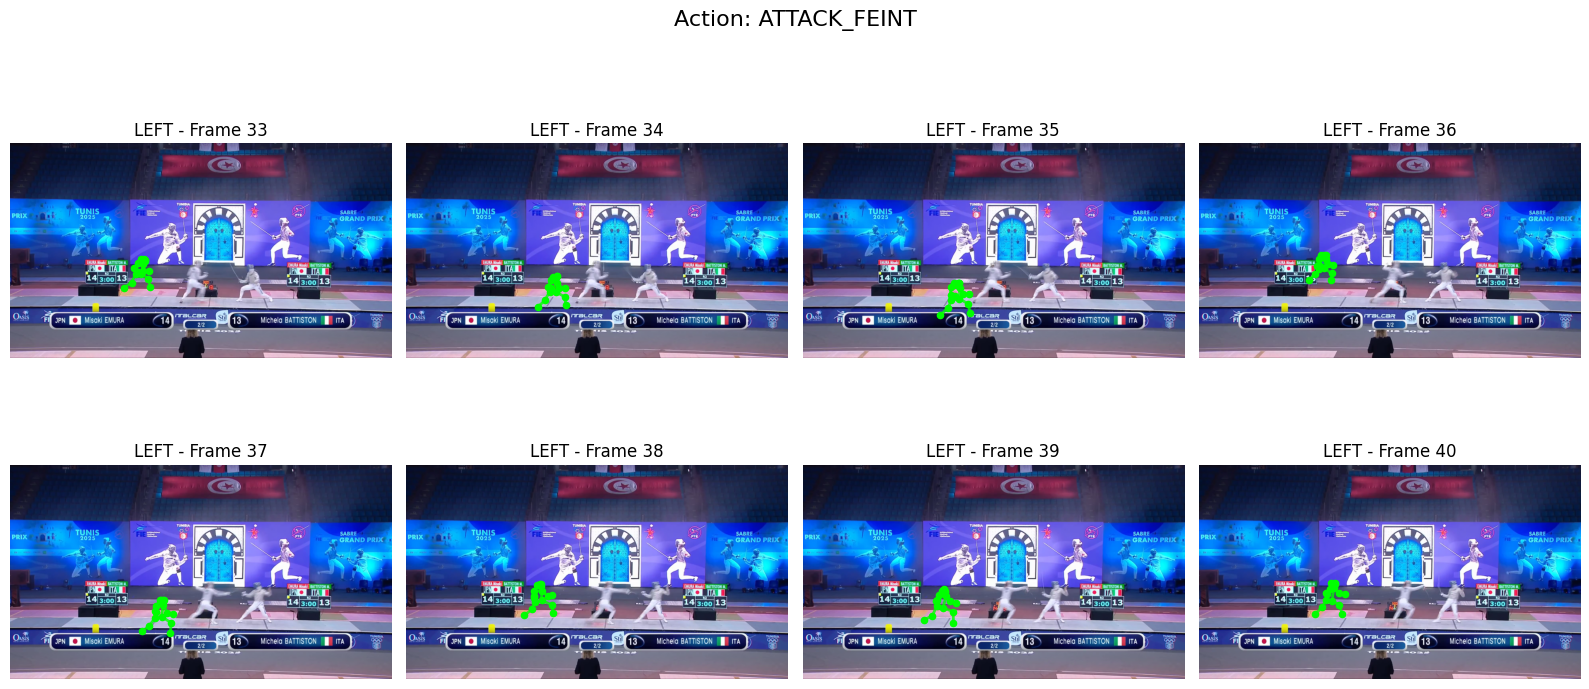

In [11]:
draw_random_window(df_augmented)

In [12]:
df_metadata = df_augmented[["file", "fencer", "action_id", "window_id", "action", "frame", "start_frame", "end_frame", "box", "confidence"]]
df_metadata.to_csv(PATH_METADATA, index=False)

df_data = df_augmented[["window_id", "frame", "action", "keypoints"]]
df_data.sort_values(["window_id"], inplace=True)

df_data = explode_keypoints(df_data)
df_data.to_csv(PATH_DATA, index=False)

/tmp/ipykernel_17163/3189362707.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.sort_values(["window_id"], inplace=True)
